# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2
import sys

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


Progressbar function

In [2]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [3]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,3),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
         Conv2DLayer3,
         ActivationLayer3,
         NormalizationLayer3,
         PoolingLayer3,
         
         Conv2DLayer4,
         ActivationLayer4,
         NormalizationLayer4,
         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        1568      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 46, 46, 32)        128       
__________

### Plot a graph of the model and save it to a file

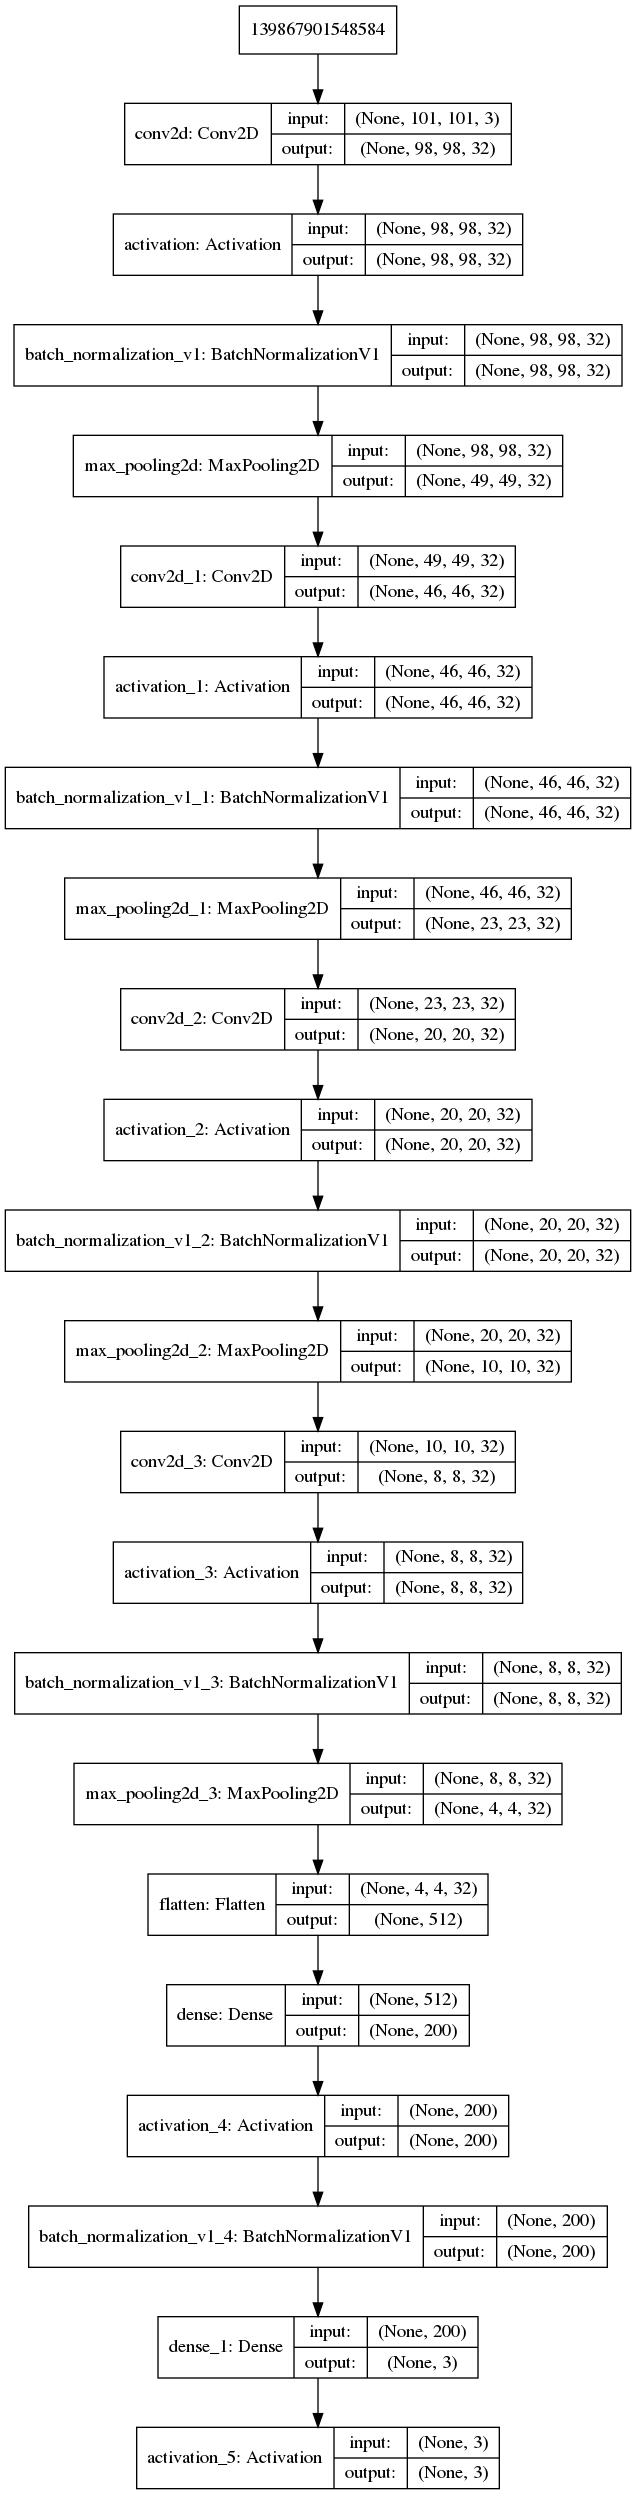

In [5]:
utils.plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'plots/model.png')
Image(retina = True, filename = 'plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk
* etc.

In [6]:
MODEL_NAME = "corridor"
DATASET_PATH = os.getcwd() + "/dataset/corridor"
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"


NUMBER_OF_EPOCHS = 100
BATCH_SIZE = 64
INIT_LEARNING_RATE = 1e-4
DECAY_LEARNING_RATE = 1e-4 / NUMBER_OF_EPOCHS

Here we can see the dataset structure:

+ dataset/corridor
    - left (X Files)
    - forward (X Files)
    - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [7]:
LABELS = list(["forward","left","right"])

Genrate a list of image pathes for our training

In [8]:
imagePaths = list(paths.list_images(DATASET_PATH))
print("Size of the dataset: " + str(len(imagePaths)))

Size of the dataset: 46219


Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [9]:
data = []
labels = []
i = 0.0

for imagePath in imagePaths:

    update_progress(i / len(imagePaths))
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    #image = imutils.resize(img, width=1280)
    image = cv2.resize(image, (101, 101))
 
    data.append(image)
    labels.append(label)


Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [10]:
data = np.array(data, dtype = "float") / 255.0

Creating one-hot encoding vectors on the labels (for each image!)

In [11]:
lb = LabelBinarizer()
hot_encoding_vectors = lb.fit_transform(labels)
#print(hot_encoding_vectors)

for i in range(len(LABELS)):
    index = labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(hot_encoding_vectors[index]))

forward:[1 0 0]
left:[0 1 0]
right:[0 0 1]


Partition the data into training and testing splits using 70% of the data for training and the remaining 30% for testing

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  hot_encoding_vectors,
                                                  test_size = 0.3,
                                                  stratify = labels,
                                                  random_state = 42)

print("Size of train dataset: " + str(len(trainX)))
print("Size of test dataset: " + str(len(testX)))

Size of train dataset: 32353
Size of test dataset: 13866


Construct the training image generator for data augmentation

In [13]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                                          zoom_range = 0.10,
                                                          width_shift_range = 0.1,
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.0,
                                                          horizontal_flip = False,
                                                          vertical_flip = False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [14]:
adamOptimizer = optimizers.Adam(lr = INIT_LEARNING_RATE, decay = DECAY_LEARNING_RATE)

After the model is constructed, configure its learning process by calling the compile method

In [15]:
model.compile(loss = "categorical_crossentropy", optimizer = adamOptimizer, metrics = ["accuracy"])

Save the entire model (HDF5 file) after every epoch (period).

In [16]:
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint('./checkpoints/'+ MODEL_NAME +'_weights{epoch:08d}.h5',
                                save_weights_only=False,
                                period=1,
                                verbose=1,
                                save_best_only=False,
                                mode='auto')

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [17]:
tf.test.is_gpu_available(cuda_only = True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [18]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(trainX, trainY, batch_size = BATCH_SIZE),
                                   validation_data = (testX, testY),
                                   steps_per_epoch = len(trainX) // BATCH_SIZE,
                                   epochs = NUMBER_OF_EPOCHS,
                                   verbose = 2,
                                   callbacks = [checkpoint_saver])

end_time = time. time()

Epoch 1/100
13866/13866 [==============================] - 5s 339us/sample - loss: 0.1742 - acc: 0.9590

Epoch 00001: saving model to ./checkpoints/corridor_weights00000001.h5
 - 88s - loss: 0.3123 - acc: 0.9003 - val_loss: 0.1742 - val_acc: 0.9590
Epoch 2/100
13866/13866 [==============================] - 5s 333us/sample - loss: 0.0878 - acc: 0.9904

Epoch 00002: saving model to ./checkpoints/corridor_weights00000002.h5
 - 79s - loss: 0.1772 - acc: 0.9566 - val_loss: 0.0877 - val_acc: 0.9904
Epoch 3/100
13866/13866 [==============================] - 5s 326us/sample - loss: 0.0870 - acc: 0.9881

Epoch 00003: saving model to ./checkpoints/corridor_weights00000003.h5
 - 78s - loss: 0.1425 - acc: 0.9702 - val_loss: 0.0870 - val_acc: 0.9881
Epoch 4/100
13866/13866 [==============================] - 5s 339us/sample - loss: 0.0707 - acc: 0.9952

Epoch 00004: saving model to ./checkpoints/corridor_weights00000004.h5
 - 79s - loss: 0.1236 - acc: 0.9762 - val_loss: 0.0706 - val_acc: 0.9952
Epoc

Epoch 34/100
13866/13866 [==============================] - 4s 315us/sample - loss: 0.0393 - acc: 0.9988

Epoch 00034: saving model to ./checkpoints/corridor_weights00000034.h5
 - 80s - loss: 0.0452 - acc: 0.9970 - val_loss: 0.0393 - val_acc: 0.9988
Epoch 35/100
13866/13866 [==============================] - 5s 327us/sample - loss: 0.0375 - acc: 0.9990

Epoch 00035: saving model to ./checkpoints/corridor_weights00000035.h5
 - 80s - loss: 0.0444 - acc: 0.9968 - val_loss: 0.0375 - val_acc: 0.9990
Epoch 36/100
13866/13866 [==============================] - 5s 329us/sample - loss: 0.0452 - acc: 0.9973

Epoch 00036: saving model to ./checkpoints/corridor_weights00000036.h5
 - 80s - loss: 0.0450 - acc: 0.9962 - val_loss: 0.0452 - val_acc: 0.9973
Epoch 37/100
13866/13866 [==============================] - 5s 328us/sample - loss: 0.0353 - acc: 0.9995

Epoch 00037: saving model to ./checkpoints/corridor_weights00000037.h5
 - 80s - loss: 0.0437 - acc: 0.9969 - val_loss: 0.0353 - val_acc: 0.9995


Epoch 67/100
13866/13866 [==============================] - 5s 329us/sample - loss: 0.0222 - acc: 0.9998

Epoch 00067: saving model to ./checkpoints/corridor_weights00000067.h5
 - 79s - loss: 0.0269 - acc: 0.9983 - val_loss: 0.0222 - val_acc: 0.9998
Epoch 68/100
13866/13866 [==============================] - 5s 329us/sample - loss: 0.0216 - acc: 0.9999

Epoch 00068: saving model to ./checkpoints/corridor_weights00000068.h5
 - 79s - loss: 0.0257 - acc: 0.9985 - val_loss: 0.0216 - val_acc: 0.9999
Epoch 69/100
13866/13866 [==============================] - 5s 330us/sample - loss: 0.0324 - acc: 0.9955

Epoch 00069: saving model to ./checkpoints/corridor_weights00000069.h5
 - 80s - loss: 0.0253 - acc: 0.9985 - val_loss: 0.0324 - val_acc: 0.9955
Epoch 70/100
13866/13866 [==============================] - 5s 331us/sample - loss: 0.0272 - acc: 0.9979

Epoch 00070: saving model to ./checkpoints/corridor_weights00000070.h5
 - 80s - loss: 0.0252 - acc: 0.9985 - val_loss: 0.0272 - val_acc: 0.9979


 - 79s - loss: 0.0165 - acc: 0.9991 - val_loss: 0.0137 - val_acc: 0.9999
Epoch 100/100
13866/13866 [==============================] - 5s 333us/sample - loss: 0.0506 - acc: 0.9879

Epoch 00100: saving model to ./checkpoints/corridor_weights00000100.h5
 - 79s - loss: 0.0172 - acc: 0.9987 - val_loss: 0.0507 - val_acc: 0.9879


In [19]:
needed_time_sec = end_time - start_time
hours = int(needed_time_sec/60/60)
minutes = int(needed_time_sec/60%60)
secondes = int(needed_time_sec%60)
print("Total training time: " + str(hours) + "[h] " + str(minutes) + "[min] " + str(secondes) + "[sec]")

Total training time: 2[h] 12[min] 20[sec]


A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the testX  data and print a classification_report

In [20]:
predictions = model.predict(testX, batch_size = BATCH_SIZE)
print(classification_report(testY.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = lb.classes_))

              precision    recall  f1-score   support

     forward       1.00      0.98      0.99      4365
        left       1.00      0.98      0.99      4381
       right       0.97      1.00      0.99      5120

   micro avg       0.99      0.99      0.99     13866
   macro avg       0.99      0.99      0.99     13866
weighted avg       0.99      0.99      0.99     13866



Plot our accuracy/loss training history and save it to disk

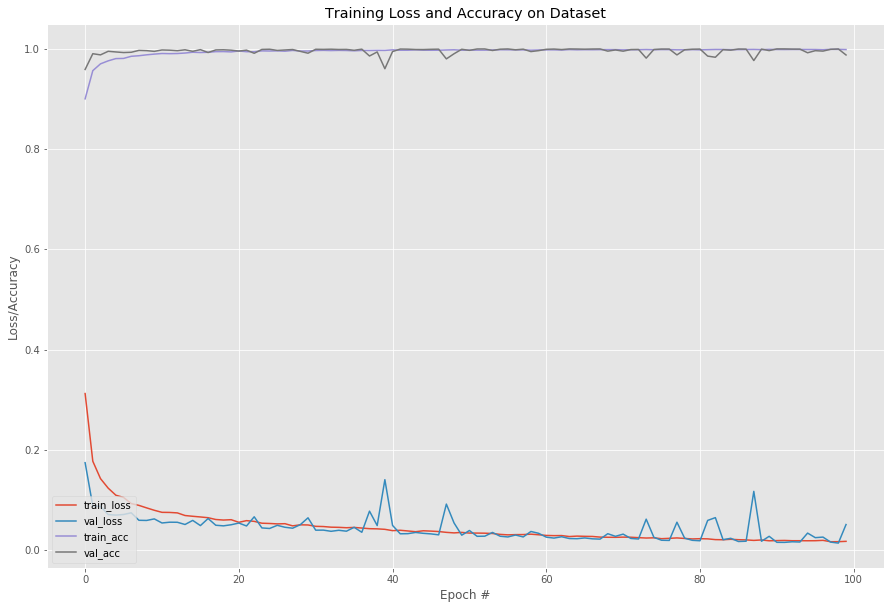

In [21]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/"+ MODEL_NAME +"_Loss_Accuracy.png")

## Saving model parameters

Save weights only (TensorFlow checkpoint file or Keras HDF5 format)

In [22]:
#model.save_weights('./weights/'+ MODEL_NAME +'_weights.ckpt')
#model.save_weights('./weights/'+ MODEL_NAME +'_weights.h5', save_format = 'h5')

Save configuration only (JSON or YAML format)

In [23]:
#import json
#import yaml

#json_string = model.to_json()
#yaml_string = model.to_yaml()

#with open('./config/data.json', 'w') as outfile:
#    json.dump(json_string, outfile)
#    
#with open('./config/data.yml', 'w') as outfile:
#    yaml.dump(yaml_string, outfile)

Save entire model (HDF5 file)

In [24]:
#model.save('./model/'+ MODEL_NAME +'_model.h5')

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/